In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

In [8]:
### Data:
# If files are moved, Make sure to setup the correct path

# --------------------------------------------------------
path_dict = {"dk_l1": "DanishL1",
             "dk_weighted": "DanishWeighted",
             "dk_l1weighted": "DanishL1Weighted",
             "multi_weighted": "Multi_weighted",
             "multi_l1weighted": "MultiL1Weighted",
             "multi_l1": "MultiL1"
             }

# --------------------------------------------------------
### Commented to save memory and avoid loading large files unnecessarily.
# cm_dict = {key : json.load(open(f"{value}/CMS_final{key.split('_')[-1].capitalize()}.json")) for key, value in path_dict.items()}
# mc_dict = {key : pd.read_csv(f"{value}/MC_final{key.split('_')[-1].capitalize()}.csv") for key, value in path_dict.items()}



# Statistics

In [9]:
seeds_dict = {"dk_l1": "Seeds/dk_l1_accuracies.csv",
              "dk_l1weighted": "Seeds/dk_l1weighted_accuracies.csv",
              "dk_weighted": "Seeds/dk_weighted_accuracies.csv",
              "multi_l1": "Seeds/Multi_L1_accuracies.csv", 
              "multi_l1weighted": "Seeds/Multi_L1_weighted_accuracies.csv",
              "multi_weighted": "Seeds/Multi_weighted_accuracies.csv",
              }

In [ ]:
def statistics(name, returns=False):
    """
    Compute and display or return mean, std, and 95% CI of final test accuracy.

    Parameters:
        name (str): Model name key to get CSV path from seeds_dict.
        returns (bool): If True, return stats instead of displaying (default False).

    Returns:
        tuple: (mean, std, (ci_lower, ci_upper)) if returns is True.
    """
    data = pd.read_csv(seeds_dict[name])["final_test_accuracy"]
    mean = data.mean()
    std = data.std()
    ts = t.ppf(0.975, df=len(data)-1)
    ci = ts * (std / np.sqrt(len(data)))
    ci_interval = (mean - ci, mean + ci)
    if returns:
        return mean, std, ci_interval
    else:
        display(f"{name} - Mean: {mean:.4f}, Std: {std:.4f}, 95% CI: {ci_interval[0]:.4f} to {ci_interval[1]:.4f}")


In [11]:
for i in seeds_dict.keys():
    statistics(i)

'dk_l1 - Mean: 0.6361, Std: 0.0146, 95% CI: 0.6256 to 0.6466'

'dk_l1weighted - Mean: 0.6344, Std: 0.0254, 95% CI: 0.6163 to 0.6526'

'dk_weighted - Mean: 0.6333, Std: 0.0280, 95% CI: 0.6133 to 0.6533'

'multi_l1 - Mean: 0.6094, Std: 0.0196, 95% CI: 0.5954 to 0.6235'

'multi_l1weighted - Mean: 0.6006, Std: 0.0238, 95% CI: 0.5835 to 0.6176'

'multi_weighted - Mean: 0.6056, Std: 0.0444, 95% CI: 0.5738 to 0.6373'

# Confusion Matrix

In [12]:
# Load confusion matrices from JSON files
cm_dict = {key : json.load(open(f"{value}/CMS_final{key.split('_')[-1].capitalize()}.json")) for key, value in path_dict.items()}

In [ ]:
def plot_cm(c_matrix, title="Confusion Matrix"):
    """
    Plot a confusion matrix heatmap with predefined class labels.

    Parameters:
        c_matrix (array-like): Confusion matrix data.
        title (str): Title of the plot (default: "Confusion Matrix").
    """
    # Class labels
    class_names = ["None", "Minimal", "Basic", "Good", "Excellent"]
    
    # Convert to numpy array if needed
    cm = np.array(c_matrix)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
def tp(multi_class_confusion_matrix):
    """Return true positives for each class from the confusion matrix."""
    return np.diag(multi_class_confusion_matrix)

def fp(multi_class_confusion_matrix):
    """Return false positives for each class from the confusion matrix."""
    return np.sum(multi_class_confusion_matrix, axis=0) - tp(multi_class_confusion_matrix)

def fn(multi_class_confusion_matrix):
    """Return false negatives for each class from the confusion matrix."""
    return np.sum(multi_class_confusion_matrix, axis=1) - tp(multi_class_confusion_matrix)

def tn(multi_class_confusion_matrix):
    """Return true negatives for each class from the confusion matrix."""
    total = np.sum(multi_class_confusion_matrix)
    return total - (tp(multi_class_confusion_matrix) + fp(multi_class_confusion_matrix) + fn(multi_class_confusion_matrix))

def precision(tp, fp):
    """Calculate precision given true positives and false positives."""
    return tp / (tp + fp) if (tp + fp).all() else np.nan

def recall(tp, fn):
    """Calculate recall given true positives and false negatives."""
    return tp / (tp + fn) if (tp + fn).all() else np.nan

def f1_score(precision, recall):
    """Calculate F1 score from precision and recall."""
    return 2 * (precision * recall) / (precision + recall) if (precision + recall).all() else np.nan

def cm_metrics(cm):
    """
    Compute TP, FP, FN, TN, Precision, Recall, and F1 Score for each class.

    Parameters:
        cm (array-like): Multi-class confusion matrix.

    Returns:
        dict: Metrics keyed by class index, each containing TP, FP, FN, TN, Precision, Recall, and F1 Score.
    """
    tp_values = tp(cm)
    fp_values = fp(cm)
    fn_values = fn(cm)
    tn_values = tn(cm)

    class_metrics = {}

    for i in range(len(cm)):
        precision_values = precision(tp_values[i], fp_values[i])
        recall_values = recall(tp_values[i], fn_values[i])
        f1_values = f1_score(precision_values, recall_values)

        class_metrics[i] = {
            "TP": tp_values[i],
            "FP": fp_values[i],
            "FN": fn_values[i],
            "TN": tn_values[i],
            "Precision": precision_values,
            "Recall": recall_values,
            "F1 Score": f1_values
        }

    return class_metrics


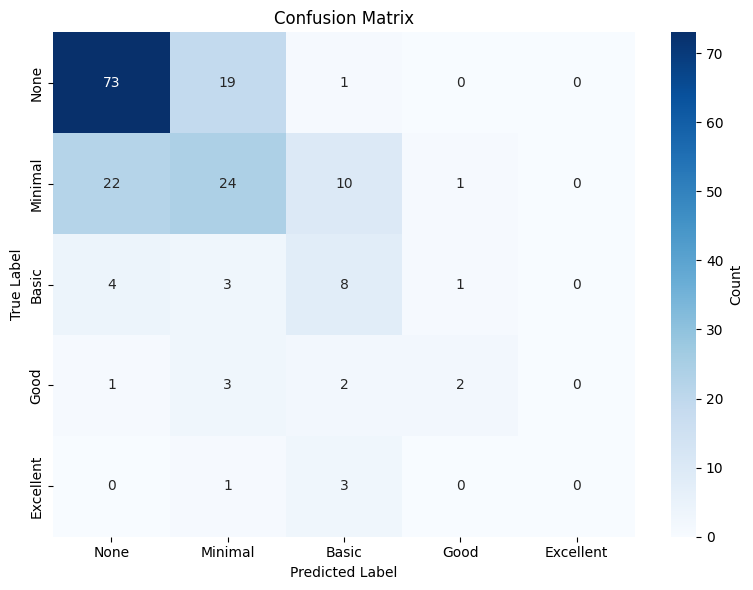

In [15]:
plot_cm(cm_dict["dk_weighted"]["epoch_100"])

In [ ]:
def ntz(value):
    """Convert NaN values to zero in a numeric input."""
    return np.nan_to_num(value, nan=0)

def weighted_f1(cm_metrics):
    """
    Calculate the weighted F1 score from class-wise confusion matrix metrics.

    Weights each class's F1 score by its support (number of true instances).

    Parameters:
        cm_metrics (dict): Dictionary of metrics per class with keys including 'TP', 'FP', 'FN', 'TN', and 'F1 Score'.

    Returns:
        float: Weighted F1 score across all classes.
    """
    f1_weighted = 0
    for label_class in cm_metrics.keys():
        N = cm_metrics[label_class]["TN"] + cm_metrics[label_class]["TP"] + cm_metrics[label_class]["FN"] + cm_metrics[label_class]["FP"]
        s = cm_metrics[label_class]["TP"] + cm_metrics[label_class]["FN"]
        f1_weighted += (s/N) * ntz(cm_metrics[label_class]["F1 Score"])
    
    return f1_weighted

    

In [17]:
### Get Weighted F1 Scores, Based of the number of CM Keys in the cd_dict
for model in cm_dict.keys():
    score = weighted_f1(cm_metrics(cm_dict[model]["epoch_100"]))
    display(f"Model: {model}, Weighted F1 Score: {score}")

'Model: dk_l1, Weighted F1 Score: 0.6525262942976097'

'Model: dk_weighted, Weighted F1 Score: 0.5898263580383607'

'Model: dk_l1weighted, Weighted F1 Score: 0.6152065102953106'

'Model: multi_weighted, Weighted F1 Score: 0.5732679723330022'

'Model: multi_l1weighted, Weighted F1 Score: 0.5616527925107804'

'Model: multi_l1, Weighted F1 Score: 0.5930364898643881'

### Reset Memory

In [ ]:
del cm_dict